In [2]:
import numpy as np
from numpy import genfromtxt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
dados = genfromtxt('dados_tratados.csv', delimiter=',')
dados.shape

(167, 13)

In [4]:
dados_X =  dados[:, :-1]
dados_y = dados[:, [-1]]

In [5]:
X_treino_full, X_teste_final, y_treino_full, y_teste_final = train_test_split(
    dados_X, dados_y, test_size=0.2, random_state=42, stratify=dados_y
)

In [6]:
class ModeloClassificador(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=12, lr=0.01, batch_size=32, epochs=300, hidden_dim=16):
        self.input_dim = input_dim
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.hidden_dim = hidden_dim
        self.loss_history = []
        self._build_model()

    def _build_model(self):
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self._build_model()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        loss_fn = nn.BCEWithLogitsLoss()

        self.loss_history = [] 

        self.model.train()
        for _ in range(self.epochs):
            total_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = self.model(xb)
                loss = loss_fn(logits, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(loader)
            self.loss_history.append(avg_loss)  

        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).squeeze(1)
            return (probs >= 0.5).int().numpy()
    
    def predict_proba(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).squeeze(1).numpy()
            return np.vstack([1 - probs, probs]).T  # formato (n amostras, 2 classes)


In [7]:
param_grid_nn = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32],
    'epochs': [300],
    'hidden_dim': [8, 16, 32]

}


In [ ]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_estimator = ModeloClassificador(input_dim=X_treino_full.shape[1])

grid_search_nn = GridSearchCV(
    estimator=nn_estimator,
    param_grid=param_grid_nn,
    scoring=make_scorer(f1_score),
    cv=cv_strategy,
    n_jobs=-1,
)


pipeline_nn = ImbPipeline([
    ('sampler', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('nn', ModeloClassificador(input_dim=X_treino_full.shape[1]))
])

print("Starting Grid Search for Neural Network...")
grid_search_nn.fit(X_treino_full, y_treino_full)

print("\n--- Neural Network Grid Search Results ---")
print(f"Best parameters found: {grid_search_nn.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_nn.best_score_:.4f}")


Starting Grid Search for Neural Network...

--- Neural Network Grid Search Results ---
Best parameters found: {'batch_size': 16, 'epochs': 300, 'hidden_dim': 16, 'lr': 0.001}
Best cross-validation F1-score: 0.8692


In [9]:
best_params = grid_search_nn.best_params_
input_dim = X_treino_full.shape[1]
best_model_nn = ModeloClassificador(input_dim=input_dim, **best_params)


In [21]:
best_model_nn.fit(X_treino_full, y_treino_full)
y_pred = best_model_nn.predict(X_teste_final)



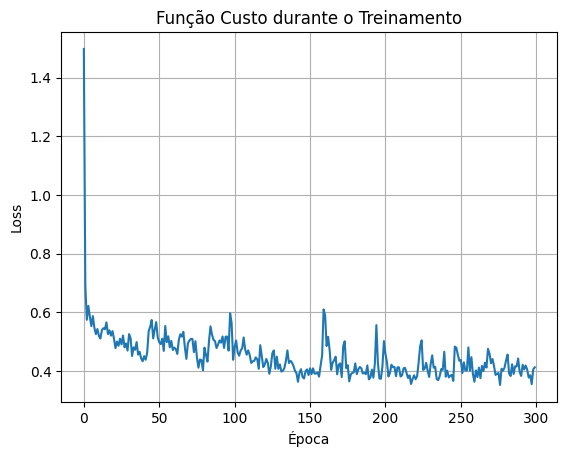

In [22]:
plt.plot(best_model_nn.loss_history)
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Função Custo durante o Treinamento")
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score, precision_score, f1_score
)

y_proba = best_model_nn.predict_proba(X_teste_final)[:, 1]  # probabilidades da classe 1
y_pred = best_model_nn.predict(X_teste_final) 

fpr, tpr, _ = roc_curve(y_teste_final, y_proba)
auc_roc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_teste_final, y_proba)
auc_pr = auc(rec, prec)

conf_matrix = confusion_matrix(y_teste_final, y_pred)

acc = accuracy_score(y_teste_final, y_pred)
recal = recall_score(y_teste_final, y_pred)
precis = precision_score(y_teste_final, y_pred)
f1 = f1_score(y_teste_final, y_pred)

print("Estatísticas Rede neural:")

print(f"Acurácia: {acc:.4f}")
print(f"Revocação: {recal:.4f}")
print(f"Precisão: {precis:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC ROC: {auc_roc:.4f}")
print(f"AUC PR: {auc_pr:.4f}")

Estatísticas Rede neural:
Acurácia: 0.6765
Revocação: 0.7200
Precisão: 0.8182
F1-score: 0.7660
AUC ROC: 0.7533
AUC PR: 0.9172


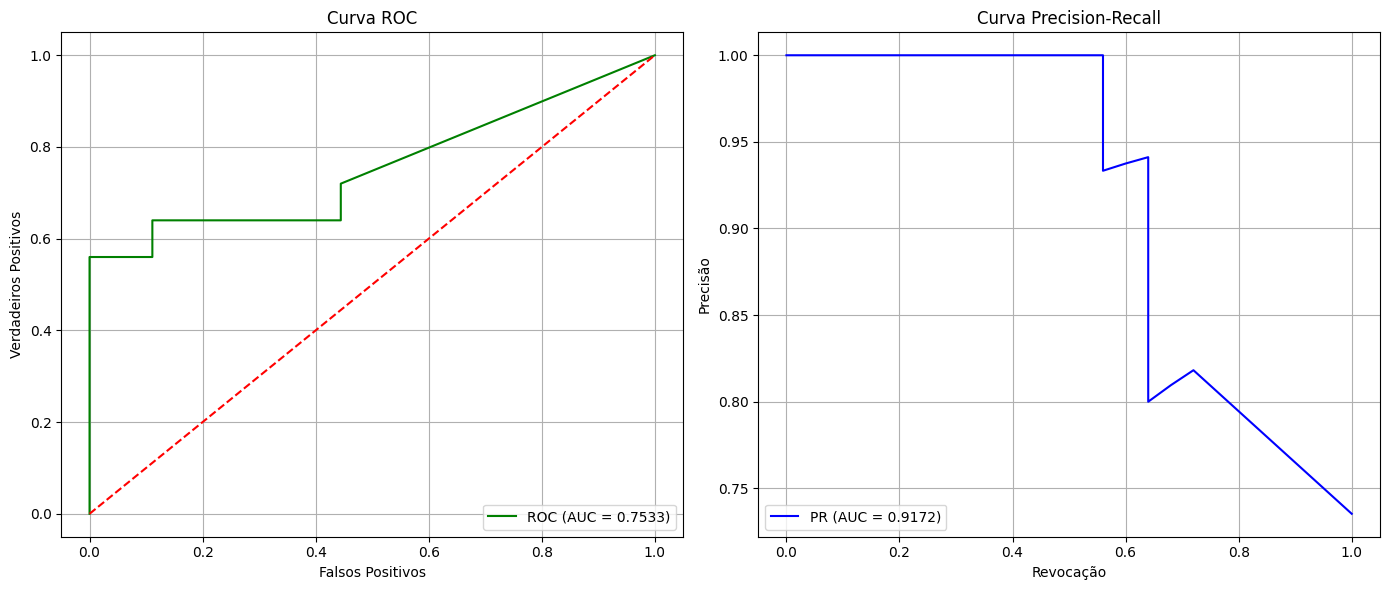

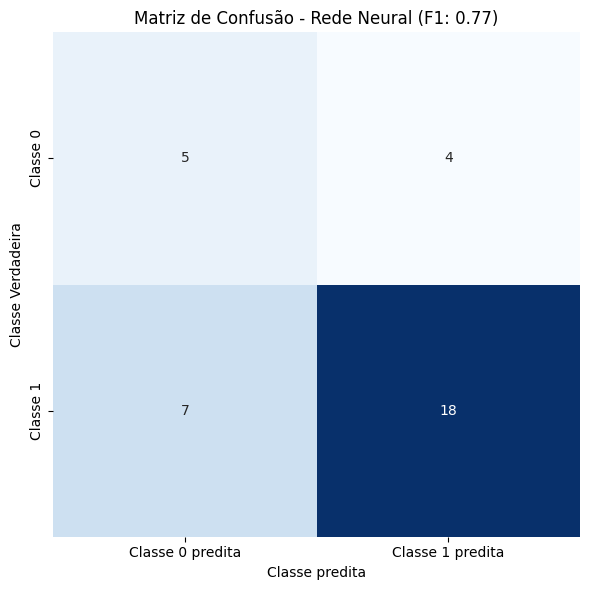

In [26]:
import seaborn as sns
# ----- Plots -----
plt.figure(figsize=(14, 6))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='green', label=f'ROC (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='blue', label=f'PR (AUC = {auc_pr:.4f})')
plt.xlabel("Revocação")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()

# ----- Matriz de Confusão -----
cm = confusion_matrix(y_teste_final, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0 predita', 'Classe 1 predita'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Classe predita')
plt.ylabel('Classe Verdadeira')
plt.title(f"Matriz de Confusão - Rede Neural (F1: {f1_score(y_teste_final, y_pred):.2f})")
plt.tight_layout()
plt.show()